# Introduction
The Northwind database contains sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world. 

The goal is to gather information from the database, and perform hypothesis testing to generate analytical insights that can be of value.

In this project, the following 7 questions will be answered. The first one is the main goal, and the rest are additional hypothesis.

* Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
* Is there a statistically significant difference in prices of shipping companies?
* Is there a statistically significant difference in order quantity each month?
* Is there a statistically significant difference in discount each month?
* Is there a statistically significant difference in discount in different categories?
* Is there a statistically significant difference in order quantity from different regions?
* Is there a statistically significant difference in order quantity in different categories?

### Import libraries

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stat
import calendar

### Retrieve data from database
Firstly, connect to the database and get a list of all the tables.

In [2]:
# connect to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
c.execute('''SELECT name FROM sqlite_master''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('sqlite_autoindex_Customer_1',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('sqlite_autoindex_OrderDetail_1',),
 ('CustomerCustomerDemo',),
 ('sqlite_autoindex_CustomerCustomerDemo_1',),
 ('CustomerDemographic',),
 ('sqlite_autoindex_CustomerDemographic_1',),
 ('Region',),
 ('Territory',),
 ('sqlite_autoindex_Territory_1',),
 ('EmployeeTerritory',),
 ('sqlite_autoindex_EmployeeTerritory_1',),
 ('ProductDetails_V',)]

### Exploratory Data Analysis (EDA)

OrderDetail is the table that is most important for this project.

In [4]:
order = pd.DataFrame(c.execute('''SELECT * from OrderDetail''').fetchall())
order.columns = [p[0] for p in c.description]
order.head(10)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10248/42,10248,42,9.8,10,0.00
2,10248/72,10248,72,34.8,5,0.00
3,10249/14,10249,14,18.6,9,0.00
4,10249/51,10249,51,42.4,40,0.00
5,10250/41,10250,41,7.7,10,0.00
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05


Here are the basic statistics.

In [5]:
order.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


All columns have 2155 values, so there are no missing data. 

Next Discount will be examined. Over half of the orders have no discount, while the maximum discount is 25%

In [6]:
order.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

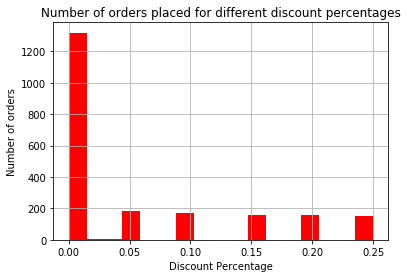

In [7]:
order.Discount.hist(bins='auto', color='red')
plt.title('Number of orders placed for different discount percentages')
plt.ylabel('Number of orders')
plt.xlabel('Discount Percentage')
plt.show()

The histogram shows that a large number (over 1200) orders are placed with 0% discount. Some orders (less than 200) are placed for 5%, 10%, 15%, 20% or 25% discount. The other discount percentages are negligible.

This leads to the main goal of this project.

## Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

**Null hypothesis $H_0$**: Discount amount have no statistically significant effect on quantity purchased in an order.

**Alternative hypothesis $H_a$**: Discount amount have a statistically significant effect on quantity purchased in an order.

Significance level: $\alpha$= 0.05

One tail Welsh's t-test can be used here. The orders are separated into 2 groups, control and experimental.

Control group has no discount, while experimental group has discount.

In [8]:
control = order[order.Discount == 0]
experimental = order[order.Discount > 0]
print(control.describe())
print(experimental.describe())

            OrderId    ProductId    UnitPrice     Quantity  Discount
count   1317.000000  1317.000000  1317.000000  1317.000000    1317.0
mean   10662.791951    41.396355    26.171534    21.715262       0.0
std      244.835366    22.217410    29.717354    17.507493       0.0
min    10248.000000     1.000000     2.000000     1.000000       0.0
25%    10448.000000    23.000000    12.000000    10.000000       0.0
50%    10671.000000    41.000000    18.400000    18.000000       0.0
75%    10879.000000    60.000000    32.800000    30.000000       0.0
max    11077.000000    77.000000   263.500000   130.000000       0.0
            OrderId   ProductId   UnitPrice    Quantity    Discount
count    838.000000  838.000000  838.000000  838.000000  838.000000
mean   10654.007160   39.844869   26.292363   27.109785    0.144439
std      235.887125   22.046812   30.017214   20.771439    0.071808
min    10250.000000    1.000000    2.000000    1.000000    0.010000
25%    10452.250000   21.000000   12.50

Without a discount, the mean quantity is 21.7, and it increases to 27.1 with discount.

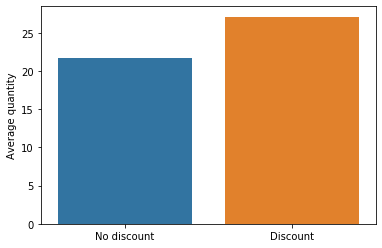

In [9]:
plt.ylabel('Average quantity')
sns.barplot(['No discount','Discount'],y=[control.Quantity.mean(),experimental.Quantity.mean()]);

In [10]:
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

With pvalue <0.05, the null hypothesis is rejected. Discount amount have a statistically significant effect on quantity purchased in an order. Cohen's d will be used to find the effect size. A value of 0.28 means the effect size is small.

In [11]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

Cohen_d(experimental.Quantity, control.Quantity)

0.2862724481729283

Next step is to find out which levels of discounts have significant impact. The Welsh t-test will be used on 5%, 10%, 15%, 20% and 25%.

In [12]:
experimental = order[order.Discount == 0.05]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=3.700844260760871, pvalue=0.00027233494432847593)

With pvalue <0.05, the null hypothesis is rejected. Discount of 5% have a statistically significant effect on quantity purchased in an order. 

In [13]:
experimental = order[order.Discount == 0.10]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=2.094434281933477, pvalue=0.0374559661063408)

With pvalue >0.05, the null hypothesis is not rejected. Discount of 10% have no statistically significant effect on quantity purchased in an order. 

In [14]:
experimental = order[order.Discount == 0.15]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=3.8356620426605934, pvalue=0.00017220729443627393)

With pvalue <0.05, the null hypothesis is rejected. Discount of 15% have a statistically significant effect on quantity purchased in an order. 

In [15]:
experimental = order[order.Discount == 0.20]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=3.4021239132172787, pvalue=0.0008110033254043408)

With pvalue <0.05, the null hypothesis is rejected. Discount of 20% have a statistically significant effect on quantity purchased in an order. 

In [16]:
experimental = order[order.Discount == 0.25]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=3.8572676240072523, pvalue=0.00015923050922125637)

With pvalue <0.05, the null hypothesis is rejected. Discount of 25% have a statistically significant effect on quantity purchased in an order. 

In conclusion, discounts of 5%, 15%, 20% and 25% have a statistically significant effect on quantity purchased in an order. Next, t-test can be performed to see if increasing discounts have any effect on quantity.

In [17]:
control = order[order.Discount == 0.05]
experimental = order[order.Discount == 0.10]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=-1.209941058797434, pvalue=0.22710466225198522)

In [18]:
control = order[order.Discount == 0.05]
experimental = order[order.Discount == 0.15]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=0.15907926596432054, pvalue=0.873701937770792)

In [19]:
control = order[order.Discount == 0.05]
experimental = order[order.Discount == 0.20]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=-0.4470597476296268, pvalue=0.6551134299813659)

In [20]:
control = order[order.Discount == 0.05]
experimental = order[order.Discount == 0.25]
stat.ttest_ind(experimental.Quantity, control.Quantity, equal_var=False)

Ttest_indResult(statistic=0.09976173385499833, pvalue=0.9205932482537716)

All of these have pvalue larger than 0.05. It shows that there is no statistically significant difference to increase discounts beyond 5%.

After the main question, here are a few more additional questions with hypothesis tests. One-way ANOVA test will be used.
## Question 1: Is there a statistically significant difference in prices of shipping companies?

If a shipping company is cheaper, Northwind should use them more for cost savings.

**Null hypothesis $H_0$**: There is no statistically significant difference in prices between different shipping companies.

**Alternative hypothesis $H_a$**: There is statistically significant difference in prices between different shipping companies.

Significance level: $\alpha$= 0.05

First, check the shipping companies from the database. There are 3 of them.

In [21]:
company = pd.DataFrame(c.execute('''SELECT * from Shipper''').fetchall())
company.columns = [p[0] for p in c.description]
company

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


Here is the Order table.

In [22]:
order = pd.DataFrame(c.execute('''SELECT * from "Order"''').fetchall())
order.columns = [p[0] for p in c.description]
order.head(10)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela


In [23]:
# collect data from database, and put into dataframe
shipping = pd.DataFrame(c.execute('''SELECT "Order".id, companyName, freight FROM Shipper JOIN "Order" ON shipvia = Shipper.id''').fetchall())
shipping.columns = [p[0] for p in c.description]
shipping.head(10)

,Id,CompanyName,Freight
0,10248,Federal Shipping,32.38
1,10249,Speedy Express,11.61
2,10250,United Package,65.83
3,10251,Speedy Express,41.34
4,10252,United Package,51.30
5,10253,United Package,58.17
6,10254,United Package,22.98
7,10255,Federal Shipping,148.33
8,10256,United Package,13.97
9,10257,Federal Shipping,81.91


Here are the number of times that each shipping company was used.

In [24]:
shipping.CompanyName.value_counts()

United Package      326
Federal Shipping    255
Speedy Express      249
Name: CompanyName, dtype: int64

Next perform the one-way ANOVA test, with CompanyName as a categorical variable.

In [25]:
formula = 'Freight ~ C(CompanyName)'
lm = ols(formula,shipping).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df        F    PR(>F)
C(CompanyName)  6.788200e+04    2.0  2.49781  0.082885
Residual        1.123753e+07  827.0      NaN       NaN


With a probability of 0.08, the null hypothesis cannot be rejected. It means there is no statistically significant difference in prices between different shipping companies.

## Question 2: Is there a statistically significant difference in order quantity each month?

Do customers place larger orders in certain months of the year? This is an interesting question for sales and logistics.

**Null hypothesis $H_0$**: There is no statistically significant difference in order quantities between different months. 

**Alternative hypothesis $H_a$**: There is a statistically significant difference in order quantities between different months. 

Significance level: $\alpha$= 0.05

In [26]:
# obtain quantity of each order from database
orders = pd.DataFrame(c.execute('''SELECT orderdate, quantity FROM "Order" JOIN OrderDetail ON "Order".id = OrderDetail.orderid''').fetchall())
orders.columns = [p[0] for p in c.description]
orders.head()

,OrderDate,Quantity
0,2012-07-04,12
1,2012-07-04,10
2,2012-07-04,5
3,2012-07-05,9
4,2012-07-05,40


In [27]:
# convert the OrderDate to month format
orders.OrderDate = pd.to_datetime(orders.OrderDate)
orders['OrderMonth'] = orders.OrderDate.dt.month

In [28]:
orders.head()

,OrderDate,Quantity,OrderMonth
0,2012-07-04,12,7
1,2012-07-04,10,7
2,2012-07-04,5,7
3,2012-07-05,9,7
4,2012-07-05,40,7


This is a bar chart for the number of orders in each month. It shows that there are most orders from January to April.

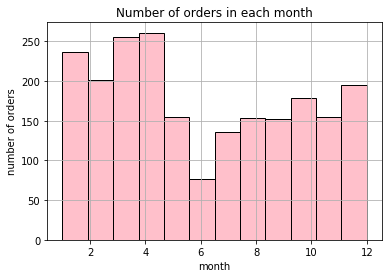

In [29]:
orders.OrderMonth.hist(bins=12, edgecolor='k', color='pink')
plt.title('Number of orders in each month')
plt.xlabel('month')
plt.ylabel('number of orders');

In [30]:
orders.OrderMonth.value_counts()

4     261
3     255
1     237
2     201
12    195
10    179
11    155
5     155
8     153
9     152
7     136
6      76
Name: OrderMonth, dtype: int64

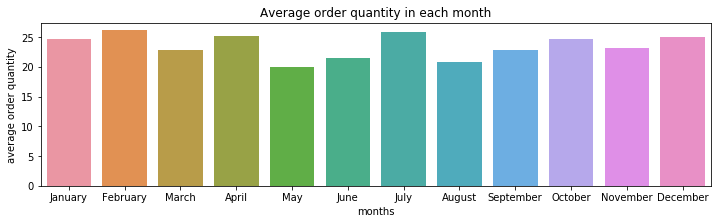

In [31]:
quantity = []
for i in range(1,13):
    quantity.append(orders[orders.OrderMonth == i].Quantity.mean())
plt.figure(figsize=(12,3))
ax = sns.barplot(calendar.month_name[1:13], quantity)
ax.set(xlabel = 'months', ylabel = 'average order quantity', title = 'Average order quantity in each month');

Next, the quantity will be tested by one-way ANOVA.

In [32]:
formula = 'Quantity ~ C(OrderMonth)'
lm = ols(formula, orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F    PR(>F)
C(OrderMonth)    7395.980026    11.0  1.866405  0.039229
Residual       772003.656168  2143.0       NaN       NaN


With a value less than $\alpha=0.05$, the null hypothesis is rejected. It means there is a statistically significant difference in order quantities between different months. Customers are placing larger orders in certain months of the year.

## Question 3: Is there a statistically significant difference in discount each month?

This is a follow up to the previous question. Is Northwind providing different discounts in different months of the year?

**Null hypothesis $H_0$**: There is no statistically significant difference in discount between different months. 

**Alternative hypothesis $H_a$**: There is a statistically significant difference in discount between different months. 

Significance level: $\alpha$= 0.05

In [33]:
# obtain discount of each order from database
orders = pd.DataFrame(c.execute('''SELECT orderdate, discount FROM "Order" JOIN OrderDetail ON "Order".id = OrderDetail.orderid''').fetchall())
orders.columns = [p[0] for p in c.description]
orders.head()

,OrderDate,Discount
0,2012-07-04,0.0
1,2012-07-04,0.0
2,2012-07-04,0.0
3,2012-07-05,0.0
4,2012-07-05,0.0


In [34]:
# convert the OrderDate to month format
orders.OrderDate = pd.to_datetime(orders.OrderDate)
orders['OrderMonth'] = orders.OrderDate.dt.month
orders.head()

,OrderDate,Discount,OrderMonth
0,2012-07-04,0.0,7
1,2012-07-04,0.0,7
2,2012-07-04,0.0,7
3,2012-07-05,0.0,7
4,2012-07-05,0.0,7


The following plot shows the average discount in each month.

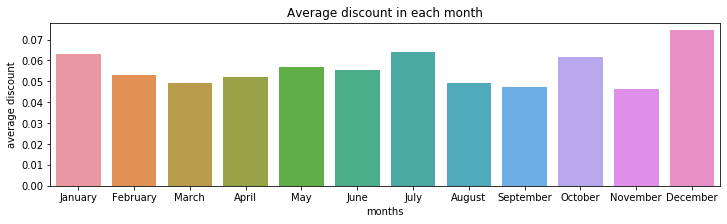

In [35]:
discounts = []
for i in range(1,13):
    discounts.append(orders[orders.OrderMonth == i].Discount.mean())
plt.figure(figsize=(12,3))
ax = sns.barplot(calendar.month_name[1:13], discounts)
ax.set(xlabel = 'months', ylabel = 'average discount', title = 'Average discount in each month');

In [36]:
# Run one-way ANOVA test 
formula = 'Discount ~ C(OrderMonth)'
lm = ols(formula, orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(OrderMonth)   0.140038    11.0  1.835891  0.043426
Residual       14.860302  2143.0       NaN       NaN


With a value less than $\alpha=0.05$, the null hypothesis is rejected. It means there is a statistically significant difference in discount between different months. Customers are getting different discounts in different months of the year.

## Question 4: Is there a statistically significant difference in discount in different categories?

This is a follow up to the previous question. Is Northwind providing different discounts in different categories of goods?

**Null hypothesis $H_0$**: There is no statistically significant difference in discount between different categories. 

**Alternative hypothesis $H_a$**: There is a statistically significant difference in discount between different categories. 

Significance level: $\alpha$= 0.05

In [37]:
# obtain discount of each order from database
orders = pd.DataFrame(c.execute('''SELECT orderid, discount, categoryid FROM Product JOIN OrderDetail ON Product.id = OrderDetail.productid''').fetchall())
orders.columns = [p[0] for p in c.description]
orders.head()

,OrderId,Discount,CategoryId
0,10248,0.0,4
1,10248,0.0,5
2,10248,0.0,4
3,10249,0.0,7
4,10249,0.0,7


In [38]:
# Run one-way ANOVA test 
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(CategoryId)   0.074918     7.0  1.539545  0.149326
Residual       14.925422  2147.0       NaN       NaN


With a value greater than $\alpha=0.05$, the null hypothesis is not rejected. Hence there is no statistically significant difference in discount between different categories.

## Question 5: Is there a statistically significant difference in order quantity from different regions?

Are customers in certain regions placing bigger or smaller orders?

**Null hypothesis $H_0$**: There is no statistically significant difference in order quantity from different regions. 

**Alternative hypothesis $H_a$**: There is a statistically significant difference in order quantity from different regions. 

Significance level: $\alpha$= 0.05

In [39]:
# obtain quantity and region of each order from database
orders = pd.DataFrame(c.execute('''SELECT quantity, orderid, region FROM OrderDetail JOIN "Order" ON "Order".id = orderdetail.orderid JOIN Customer ON Customer.id = "Order".customerid''').fetchall())
orders.columns = [p[0] for p in c.description]
orders.head()

,Quantity,OrderId,Region
0,12,10248,Western Europe
1,10,10248,Western Europe
2,5,10248,Western Europe
3,9,10249,Western Europe
4,40,10249,Western Europe


There are customers from 9 different regions.

In [40]:
regions = orders.Region.unique()
regions

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

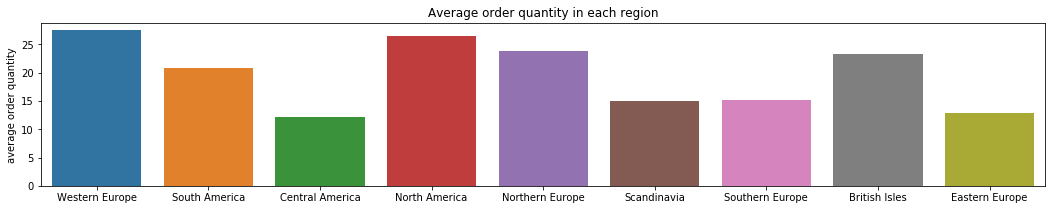

In [41]:
quantity = []
for i in range(0,9):
    quantity.append(orders[orders.Region == regions[i]].Quantity.mean())
plt.figure(figsize=(18,3))
ax = sns.barplot(x=regions, y=quantity)
ax.set(ylabel = 'average order quantity', title = 'Average order quantity in each region');

In [42]:
# Run one-way ANOVA test 
formula = 'Quantity ~ C(Region)'
lm = ols(formula, orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df          F        PR(>F)
C(Region)   40817.353539     8.0  14.641888  5.449622e-21
Residual   720971.784575  2069.0        NaN           NaN


With such small value, the null hypothesis is rejected. There is a statistically significant difference in order quantity from different regions.

## Question 6: Is there a statistically significant difference in order quantity in different categories?

**Null hypothesis $H_0$**: There is no statistically significant difference in order quantity between different categories. 

**Alternative hypothesis $H_a$**: There is a statistically significant difference in order quantity between different categories. 

Significance level: $\alpha$= 0.05

In [43]:
# obtain discount of each order from database
orders = pd.DataFrame(c.execute('''SELECT orderid, quantity, categoryid FROM Product JOIN OrderDetail ON Product.id = OrderDetail.productid''').fetchall())
orders.columns = [p[0] for p in c.description]
orders.head()

,OrderId,Quantity,CategoryId
0,10248,12,4
1,10248,10,5
2,10248,5,4
3,10249,9,7
4,10249,40,7


In [44]:
# Run one-way ANOVA test 
formula = 'Quantity ~ C(CategoryId)'
lm = ols(formula, orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F    PR(>F)
C(CategoryId)    1292.377084     7.0  0.509429  0.828058
Residual       778107.259110  2147.0       NaN       NaN


With a value greater than $\alpha=0.05$, the null hypothesis is not rejected. Hence there is no statistically significant difference in order quantity between different categories.

## Conclusion

* There is no statistically significant difference in prices between different shipping companies. They have similar shipping charges.
* There is a statistically significant difference in order quantities between different months. Customers are placing larger orders in certain months of the year.
* There is a statistically significant difference in discount between different months. Customers are getting different discounts in different months of the year.
* There is no statistically significant difference in discount between different categories.
* There is a statistically significant difference in order quantity from different regions.
* There is no statistically significant difference in order quantity between different categories. Customers are ordering similar quantity for different categories of goods.

## Recommendations
* Provide a discount of 5%, do not give out discounts > 5%.
* Increase marketing efforts in Central America, Scandinavia, Southern Europe and Eastern Europe.
* Find out the efficiency of each shipping company. Given their similar shipping charges, it makes sense to use the one with quickest delivery time.

## Future work
* Find out the seasonal ordering pattern from our customers. What kinds of products have larger demand in certain months of the year?
* Implement a customer loyalty program
* Try to give out extra discount in months with lower sales, such as June, and see if sales improves.
* Find out the reason Scandinavia is not performing as well as Western Europe and Northern Europe.